In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import json
from itertools import chain
import copy

import Bio
from Bio import SeqIO
from Bio import AlignIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Align import substitution_matrices

import matplotlib.pyplot as plt

In [2]:
def load_lib(jsonlf):
    data = {
        'accession': [],
        'length': [],
        'location': [],
        'releaseDate': [],
    }
    for line in tqdm(jsonlf, position=0, leave=True, desc='reading lib file'):
        info = json.loads(line)
        if info['completeness']=='COMPLETE' and info['length']>27000:
            try:
                data['location'].append(info['location']['geographicLocation'])
            except:
                data['location'].append('Unknown')
            data['accession'].append(info['accession'])
            data['length'].append(info['length'])
            data['releaseDate'].append(info['releaseDate'])
    libdf = pd.DataFrame(data=data)
    libdf = libdf.sort_values(by=['releaseDate']).dropna()
    
    return libdf


def load_seq(fastapath, mode):
    sequences = {}
    for seq_record in tqdm(SeqIO.parse(fastapath,mode), position=0, leave=True, desc='reading fasta file'):
        sequences[seq_record.id] = seq_record.seq.replace('N','')
    
    return sequences

In [3]:
all_genomic_path = './../ncbi_dataset/data/genomic.fna'
complete_genomic_path = './../ncbi_dataset/data/complete_genome.fasta'
protein_path = './../ncbi_dataset/data/protein.faa'
libpath = './../ncbi_dataset/data/data_report.jsonl'

In [ ]:
%%time
jsonlf = open(libpath,'r').readlines()
lib = load_lib(jsonlf)

In [ ]:
%%time
sequences = load_seq(complete_genomic_path, 'fasta')

In [6]:
acclist = lib.accession.tolist()
maxlen = lib.length.max()
minlen = lib.length.min()

In [7]:
print(len(acclist))
print(minlen, maxlen)

1001653
27366 30119


In [8]:
liblen = lib.sort_values(by=['length'],ascending=False).dropna()

In [9]:
print(liblen.head())

         accession  length                         location releaseDate
70312   MT844089.1   30119                          Unknown  2020-09-07
879886  MT079851.1   30018                            China  2020-05-15
385503  MT079845.1   29955                            China  2020-05-15
17088   MT121215.1   29945                  China: Shanghai  2020-03-09
614766  MZ472103.1   29940  USA: Kentucky, Jefferson County  2021-08-13


In [30]:
uni_seq = {}
seq_stat = np.zeros((5,maxlen)) # A T C G -
maxlen_acc = lib[lib.length==maxlen].accession.item()
maxlen_seq = str(sequences[maxlen_acc])
uni_seq[maxlen_acc] = maxlen_seq
for j in range(len(maxlen_seq)):
    if maxlen_seq[j] == 'A': seq_stat[0,j] += 1
    elif maxlen_seq[j] == 'T': seq_stat[1,j] += 1
    elif maxlen_seq[j] == 'C': seq_stat[2,j] += 1
    elif maxlen_seq[j] == 'G': seq_stat[3,j] += 1
    elif maxlen_seq[j] == '-': seq_stat[4,j] += 1

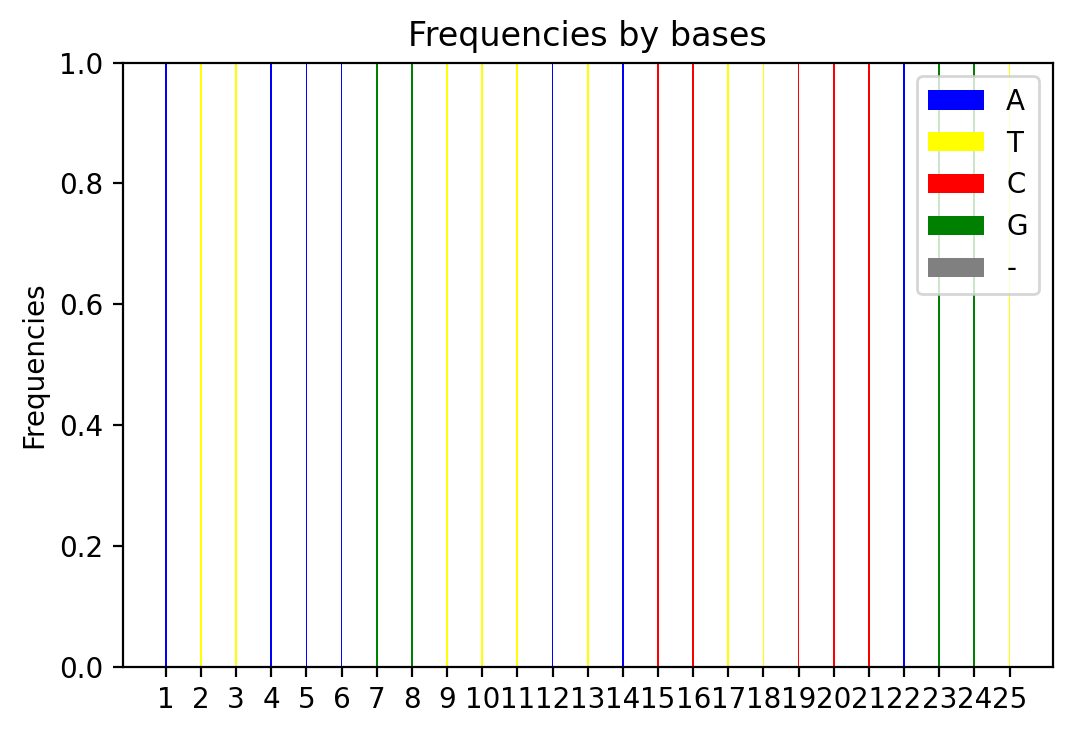

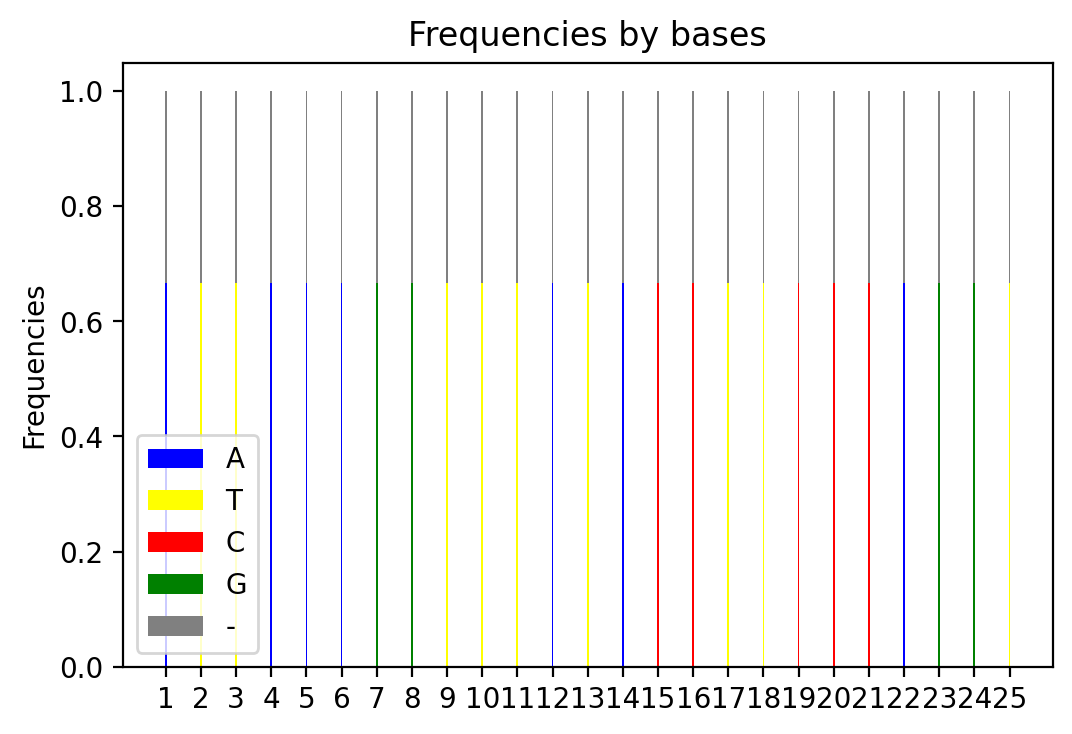

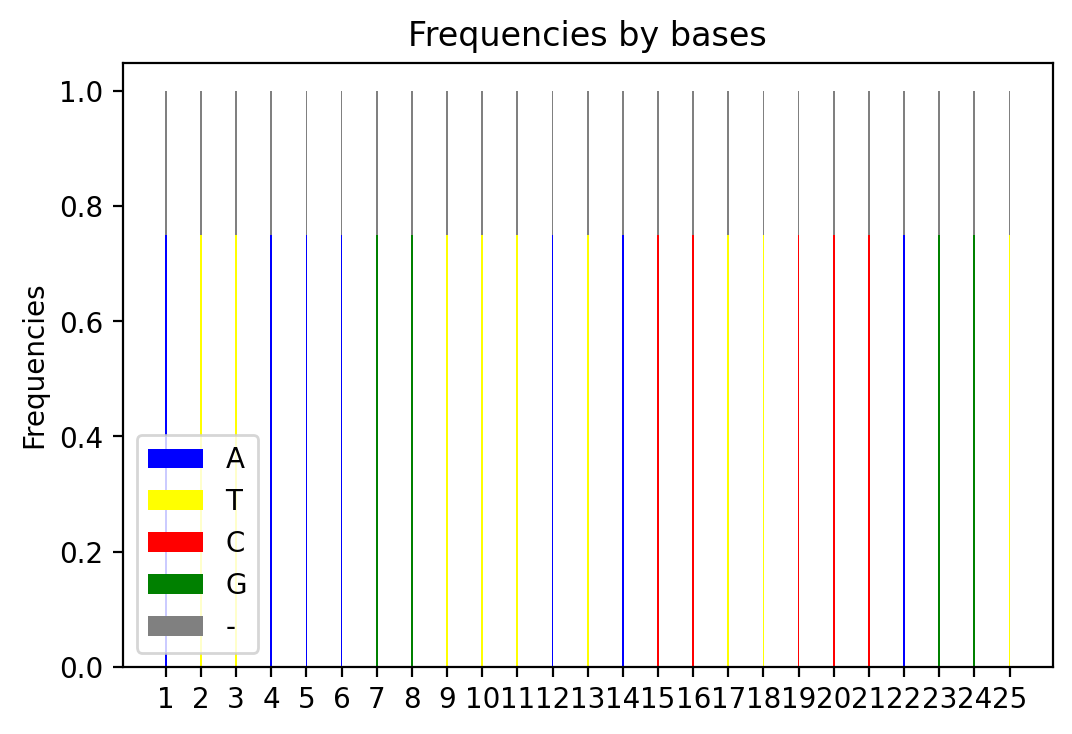

KeyboardInterrupt: 

In [31]:
for i in range(len(acclist)-1):
    seq1, seq2 = sequences[acclist[i]], sequences[acclist[i+1]]
    alignment = pairwise2.align.globalms(seq1, seq2, 2,-1,-10,-0.5, one_alignment_only=True)
    seqB = str(alignment[0].seqB)
    uni_seq[acclist[i+1]] = seqB
    for k in range(len(seqB)):
        if seqB[k] == 'A': seq_stat[0,k] += 1
        elif seqB[k] == 'T': seq_stat[1,k] += 1
        elif seqB[k] == 'C': seq_stat[2,k] += 1
        elif seqB[k] == 'G': seq_stat[3,k] += 1
        elif seqB[k] == '-': seq_stat[4,k] += 1
    freqs = seq_stat/seq_stat.sum(axis=0)
    freqA, freqT, freqC, freqG, freqn = freqs[0,:25], freqs[1,:25], freqs[2,:25], freqs[3,:25], freqs[4,:25]
    labels = [str(n) for n in range(1,1+25)]
    width = 0.05
    fig, ax = plt.subplots(dpi=200)
    ax.bar(x=labels, height=freqA, width=width, linewidth=0, label='A', color='blue')
    ax.bar(x=labels, height=freqT, width=width, linewidth=0, label='T', color='yellow', bottom=freqA)
    ax.bar(x=labels, height=freqC, width=width, linewidth=0, label='C', color='red', bottom=freqT+freqA)
    ax.bar(x=labels, height=freqG, width=width, linewidth=0, label='G', color='green', bottom=freqC+freqT+freqA)
    ax.bar(x=labels, height=freqn, width=width, linewidth=0, label='-', color='grey', bottom=freqG+freqC+freqT+freqA)
    ax.set_ylabel('Frequencies')
    ax.set_title('Frequencies by bases')
    ax.legend()
    plt.show()

In [10]:
minlen_seq = str(sequences[lib[lib.length==minlen].accession.item()])

In [17]:
%%time
alignments = pairwise2.align.globalms(maxlen_seq, minlen_seq, 2,-1,-10,-0.5, one_alignment_only=True)

CPU times: user 57.1 s, sys: 31.8 s, total: 1min 28s
Wall time: 1min 29s


In [18]:
print(len(alignments))

1


In [19]:
print(alignments[0].seqA[:100])
print(alignments[0].seqB[:100])

ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC
--------------------------------------------------------------------------CTTTAAAATCTGTGTGGCTGTCACTC


In [21]:
for a in alignments:
    print(len(a.seqA),len(a.seqB))

30119 30119


In [33]:
acclist = lib['accession'].tolist()
outfasta = './../ncbi_dataset/data/complete_genome.fasta'
with open(outfasta,'w') as f:
    for acc in tqdm(acclist, position=0, leave=True, desc='writing new fasta file'):
        content = '>'+acc+'\n'+str(sequences[acc])+'\n'
        f.write(content)

writing new fasta file: 100%|██████████| 1001653/1001653 [01:09<00:00, 14407.87it/s]
